In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
import numpy as np

In [2]:
# Load and Clean the Datasets
fixed_text_typing_df = pd.read_csv('FixedTextTypingDataset.csv', delimiter=';', engine='python')
free_text_typing_df = pd.read_csv('FreeTextTypingDataset.csv', delimiter=';', engine='python')
frequency_df = pd.read_csv('FrequencyDataset.csv', delimiter=';', engine='python')

# Drop any rows with NaN values that resulted from the parsing errors
fixed_text_typing_df.dropna(inplace=True)
free_text_typing_df.dropna(inplace=True)
frequency_df.dropna(inplace=True)

In [3]:
df = fixed_text_typing_df
print("Initial CSV shape:", df.shape)
print("Missing values per column:\n", df.isna().sum())
print("First few rows:\n", df.head())

Initial CSV shape: (18445, 14)
Missing values per column:
 userId          0
emotionIndex    0
index           0
keyCode         0
keyDown         0
keyUp           0
D1U1            0
D1U2            0
D1D2            0
U1D2            0
U1U2            0
D1U3            0
D1D3            0
answer          0
dtype: int64
First few rows:
      userId emotionIndex  index keyCode   keyDown     keyUp D1U1  D1U2  \
283     100            H   3731  \u0014  1,58E+12  1,58E+12  111   433   
284     100            H   3732       w  1,58E+12  1,58E+12  102   561   
285     100            H   3733       e  1,58E+12  1,58E+12   76  1054   
286     100            H   3734      \b  1,58E+12  1,58E+12   91   431   
287     100            H   3735  \u0014  1,58E+12  1,58E+12  114  2025   

       D1D2  U1D2  U1U2  D1U3    D1D3 answer  
283   331.0   220   322   892   816.0      R  
284   485.0   383   459  1539  1448.0      R  
285   963.0   887   978  1394  1280.0      R  
286   317.0   226   340  2

In [4]:
# Feature Extraction
import math 

def extract_features(df):
    
    # Convert relevant columns to numeric types
    df['keyDown'] = pd.to_numeric(df['keyDown'], errors='coerce')
    df['keyUp'] = pd.to_numeric(df['keyUp'], errors='coerce')
    df['D1D2'] = pd.to_numeric(df['D1D2'], errors='coerce')

    df.dropna(subset=['keyDown', 'keyUp', 'D1D2'])
        
    features = []
    labels = []

    for _, row in df.iterrows():
        key_down_up_diff = row['keyUp'] - row['keyDown']
        if (math.isnan(key_down_up_diff)):
            key_down_up_diff = 0
        inter_key_time = row['D1D2']
        features.append([key_down_up_diff, inter_key_time])
        labels.append(row['emotionIndex'])  # Adjust to your column name

    return np.array(features), np.array(labels)


# Example: Extracting features from the fixed text dataset
# fixed_text_features = extract_features(fixed_text_typing_df)
# fixed_text_labels = fixed_text_typing_df['emotionIndex'].values
fixed_text_features, fixed_text_labels = extract_features(fixed_text_typing_df)

In [5]:
# Encoding the labels
label_encoder = LabelEncoder()
fixed_text_labels_encoded = label_encoder.fit_transform(fixed_text_labels)

print("Extracted features shape:", fixed_text_features.shape)
print("Extracted labels shape:", len(fixed_text_labels_encoded))

X_train, X_temp, y_train, y_temp = train_test_split(
    fixed_text_features, fixed_text_labels_encoded, test_size=0.2, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

Extracted features shape: (18445, 2)
Extracted labels shape: 18445


In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(14756, 2)
(1844, 2)
(1845, 2)


In [7]:
print(set(y_train), set(y_test), set(y_val))

{0, 1, 2, 3} {0, 1, 2, 3} {0, 1, 2, 3}


In [8]:
# Define PyTorch Dataset and DataLoader
class KeystrokeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = KeystrokeDataset(X_train, y_train)
validation_dataset = KeystrokeDataset(X_val, y_val)
test_dataset = KeystrokeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:

# Define a deeper feedforward neural network
class DeepEmotionClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DeepEmotionClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

input_size = 2  # Number of input features
num_classes = len(label_encoder.classes_)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DeepEmotionClassifier(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with tracking
num_epochs = 50
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        outputs = model(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for features, labels in validation_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    val_accuracies.append(accuracy)
    if (epoch%5==0): 
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/50], Loss: 1.3832, Accuracy: 0.2565
Epoch [6/50], Loss: 1.3803, Accuracy: 0.2777
Epoch [11/50], Loss: 1.3800, Accuracy: 0.2847
Epoch [16/50], Loss: 1.3791, Accuracy: 0.2489
Epoch [21/50], Loss: 1.3794, Accuracy: 0.2744
Epoch [26/50], Loss: 1.3788, Accuracy: 0.2646
Epoch [31/50], Loss: 1.3792, Accuracy: 0.2565
Epoch [36/50], Loss: 1.3785, Accuracy: 0.2793
Epoch [41/50], Loss: 1.3777, Accuracy: 0.2581
Epoch [46/50], Loss: 1.3777, Accuracy: 0.2706


In [12]:
 # Evaluation
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_targets, all_preds)
print(f'Test accuracy: {accuracy}')

Test accuracy: 0.3040650406504065


In [13]:
# Map model outputs to emotional states
def predict_emotion(model, features):
    model.eval()
    with torch.no_grad():
        features = torch.tensor(features, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        return label_encoder.inverse_transform(predicted.cpu().numpy())

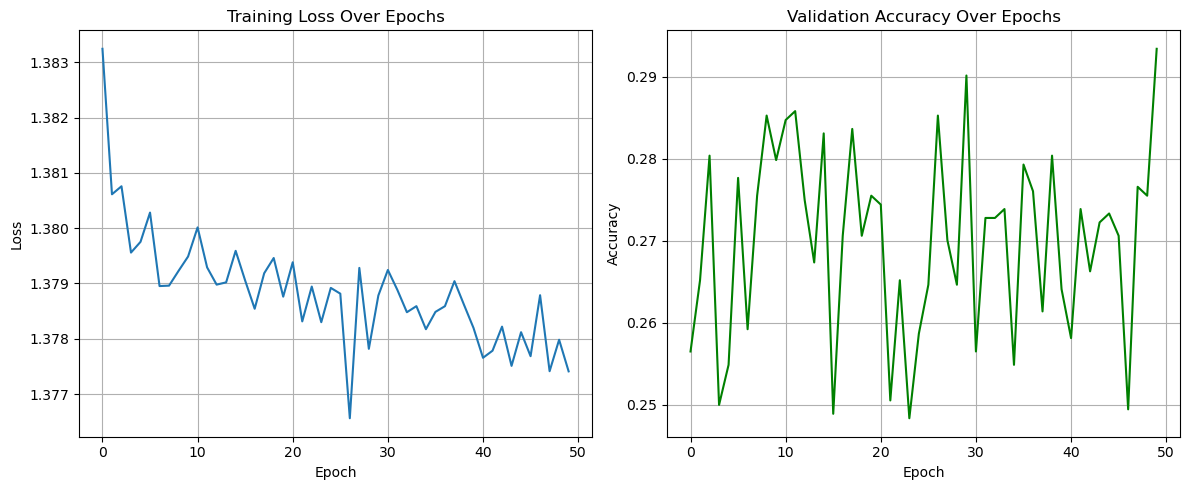

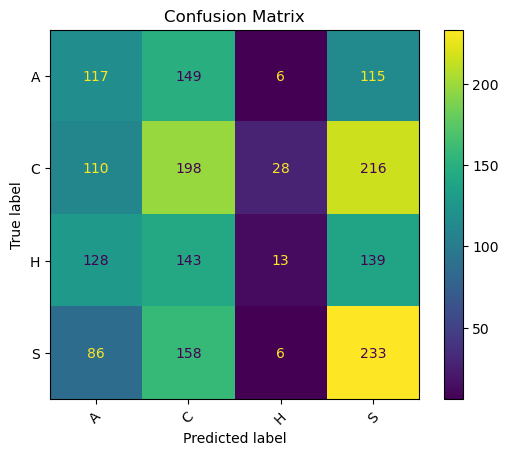

In [14]:
import matplotlib.pyplot as plt

# Plotting training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
